In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
from av2.datasets.sensor.av2_sensor_dataloader import AV2SensorDataLoader
from pathlib import Path
from av2.structures.sweep import Sweep
from config import CONFIG

In [3]:
home = os.path.join(os.path.expanduser('~'), CONFIG['HOME_PATH'][CONFIG['OS']])

# dataset_path = Path(os.path.join(home, *CONFIG['AV2_DATASET_PATH']))

# av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

In [4]:
# scene_idx = 0
# frame_idx = 0

# scene_id = av2.get_log_ids()[scene_idx]
# frame_id = av2.get_ordered_log_lidar_timestamps(scene_id)[frame_idx]
# frame_path = av2.get_lidar_fpath_at_lidar_timestamp(scene_id, frame_id)

# points = Sweep.from_feather(frame_path).xyz

TASK: To plot the mAP values of two parameters for rect_filter

How to do this?
+ iterate through all the combinations in grid_search directory
+ for each combination of maximum aspect ratio and area find the mAP for IOU = 0.3 and 0.5
+ save it. Maybe create a grid.
+ Once you have the grid, think about how to create the plot

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def gather_map_values(root_dir):
    """
    Recursively collects mean mAP at IOU=0.3 and IOU=0.5 
    for each (ar_threshold, area_threshold) combination under `root_dir`.
    """
    records = []

    # Loop over subdirs like "ar_threshold_0.1", "ar_threshold_0.2", etc.
    for ar_dir in sorted(os.listdir(root_dir)):
        if not ar_dir.startswith("ar_threshold_"):
            continue
        # Extract the numeric aspect-ratio value
        ar_str = ar_dir.replace("ar_threshold_", "")
        try:
            ar_val = float(ar_str)
        except ValueError:
            # Not a valid numeric directory name
            continue
        
        ar_path = os.path.join(root_dir, ar_dir)

        # Now loop over area subdirs like "area_threshold_0", "area_threshold_2", ...
        for area_dir in sorted(os.listdir(ar_path)):
            if not area_dir.startswith("area_threshold_"):
                continue
            # Extract the numeric area value
            area_str = area_dir.replace("area_threshold_", "")
            try:
                area_val = float(area_str)
            except ValueError:
                continue

            area_path = os.path.join(ar_path, area_dir)

            # Collect all feather files for IOU=0.3 and IOU=0.5
            iou03_paths = glob.glob(os.path.join(area_path, "**", "iou_0.3_.feather"), recursive=True)
            iou05_paths = glob.glob(os.path.join(area_path, "**", "iou_0.5_.feather"), recursive=True)

            iou03_vals = []
            iou05_vals = []

            # Read the mAP from each iou_0.3_.feather
            for fpath in iou03_paths:
                df = pd.read_feather(fpath)
                iou03_vals.append(df.loc[0, "mAP"])  # Each .feather presumably has 1-row per file

            # Read the mAP from each iou_0.5_.feather
            for fpath in iou05_paths:
                df = pd.read_feather(fpath)
                iou05_vals.append(df.loc[0, "mAP"])

            # Compute averages (or NaN if none found)
            mean_mAP_03 = np.mean(iou03_vals) if len(iou03_vals) > 0 else np.nan
            mean_mAP_05 = np.mean(iou05_vals) if len(iou05_vals) > 0 else np.nan

            # Store in a list of dicts
            records.append({
                "ar_threshold": ar_val,
                "area_threshold": area_val,
                "mean_mAP_0.3": mean_mAP_03,
                "mean_mAP_0.5": mean_mAP_05
            })
    
    # Convert collected rows to a DataFrame
    df = pd.DataFrame(records)
    return df

In [6]:
# Set your root directory here
root_dir = os.path.join(home, *CONFIG['GRID_SEARCH_METRICS_PATH']['ROI']['RECT_FILTER_PATH'])

# Collect data into a single DataFrame
df = gather_map_values(root_dir)

# Pivot into 2D form for each IOU threshold, for heatmaps
# row index is "ar_threshold", column is "area_threshold"
df_03 = df.pivot(index="ar_threshold", columns="area_threshold", values="mean_mAP_0.3")
df_05 = df.pivot(index="ar_threshold", columns="area_threshold", values="mean_mAP_0.5")


In [7]:
df_03

area_threshold,0.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0
ar_threshold,,,,,,,,,,,
0.1,0.081049,0.094242,0.094286,0.094074,0.094610,0.094884,0.094705,0.094620,0.094572,0.094517,0.087511
0.2,0.081049,0.100567,0.100662,0.100807,0.102021,0.103395,0.103322,0.103575,0.103331,0.103080,0.092525
0.3,0.081049,0.108956,0.108933,0.105987,0.105213,0.105476,0.106408,0.106511,0.106913,0.106648,0.096834
0.4,0.081049,0.121687,0.121830,0.115770,0.097110,0.088816,0.088977,0.087311,0.086793,0.086641,0.078229
0.5,0.081049,0.132602,0.135728,0.119698,0.082380,0.063474,0.062136,0.059547,0.058406,0.058106,0.054729


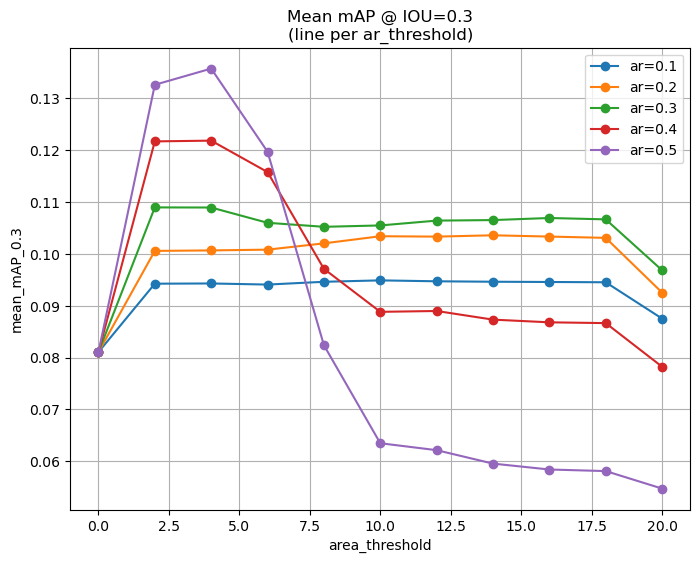

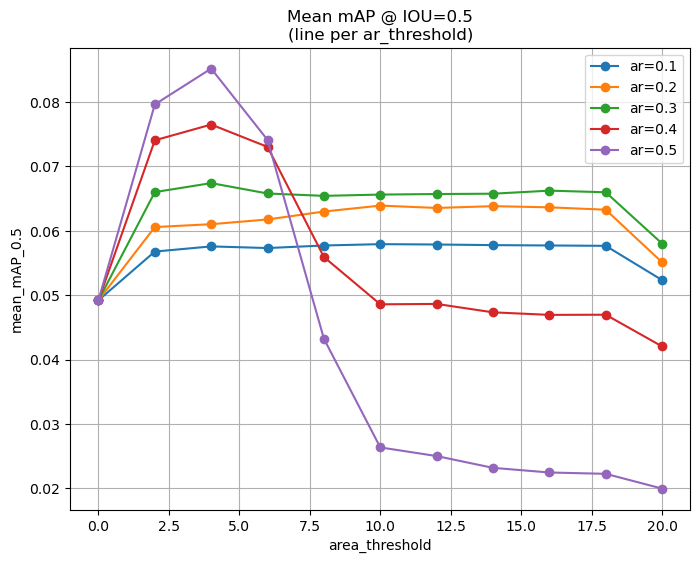

In [8]:
import matplotlib.pyplot as plt

def plot_map_vs_area(df, mAP_col="mean_mAP_0.3", title="Mean mAP @ IOU=0.3"):
    # Unique ar_thresholds in ascending order
    ar_vals = sorted(df["ar_threshold"].unique())
    
    plt.figure(figsize=(8, 6))
    for ar in ar_vals:
        # Subset the data for this ar_threshold
        sub = df[df["ar_threshold"] == ar].sort_values("area_threshold")
        plt.plot(
            sub["area_threshold"],
            sub[mAP_col],
            marker="o",
            label=f"ar={ar}"
        )
    
    plt.xlabel("area_threshold")
    plt.ylabel(mAP_col)
    plt.title(title + "\n(line per ar_threshold)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage for IOU=0.3 and IOU=0.5:
plot_map_vs_area(df, "mean_mAP_0.3", "Mean mAP @ IOU=0.3")
plot_map_vs_area(df, "mean_mAP_0.5", "Mean mAP @ IOU=0.5")


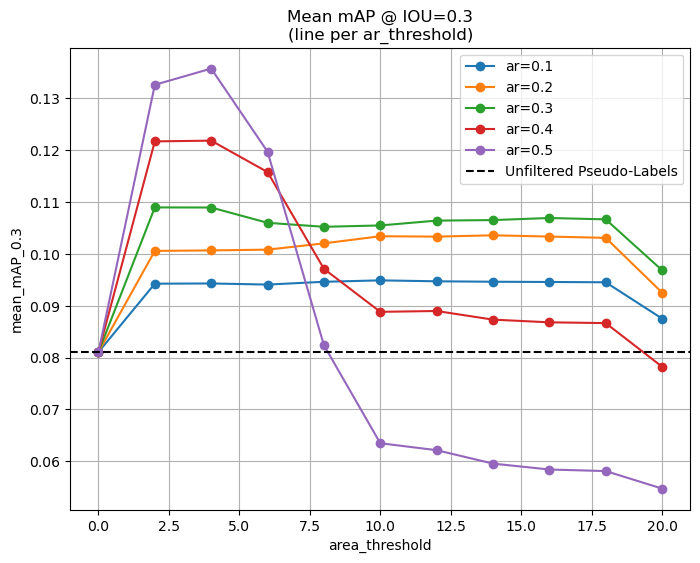

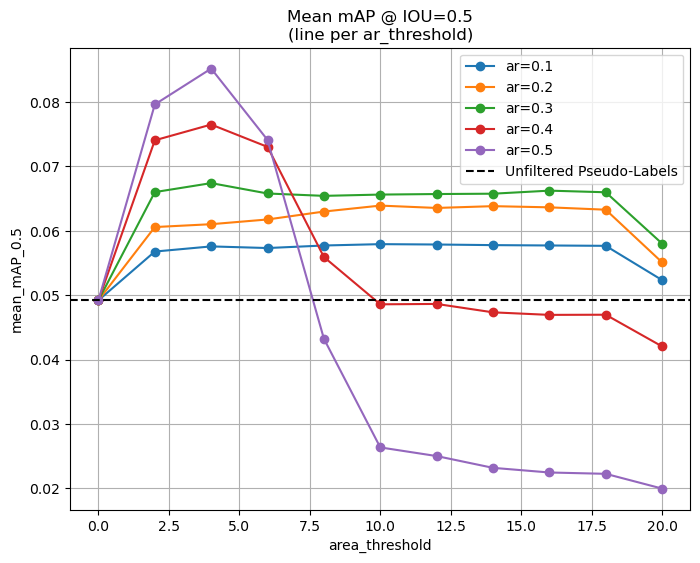

In [10]:
import matplotlib.pyplot as plt

def plot_map_vs_area(
    df,
    mAP_col="mean_mAP_0.3",
    baseline=None,
    title="Mean mAP @ IOU=0.3"
):
    """
    Plots mean_mAP vs. area_threshold, one line per ar_threshold.
    Optionally draws a horizontal baseline (dashed line) at 'baseline'.
    """
    # Get ar_thresholds in ascending order
    ar_vals = sorted(df["ar_threshold"].unique())

    plt.figure(figsize=(8, 6))
    
    # Plot a separate line for each ar_threshold
    for ar in ar_vals:
        sub = df[df["ar_threshold"] == ar].sort_values("area_threshold")
        plt.plot(
            sub["area_threshold"],
            sub[mAP_col],
            marker="o",
            label=f"ar={ar}"
        )
    
    # Draw a horizontal line if a baseline is provided
    if baseline is not None:
        plt.axhline(y=baseline, color="black", linestyle="--", label="Unfiltered Pseudo-Labels")
    
    plt.xlabel("area_threshold")
    plt.ylabel(mAP_col)
    plt.title(f"{title}\n(line per ar_threshold)")
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage:
# Suppose from your printout you see "Normal Pseudo-labels: mAP = 0.081..." at IOU=0.3
# and "Normal Pseudo-labels: mAP = 0.049..." at IOU=0.5. 
baseline_iou03 = 0.0810
baseline_iou05 = 0.0492

# For IOU=0.3
plot_map_vs_area(
    df,
    mAP_col="mean_mAP_0.3",
    baseline=baseline_iou03,
    title="Mean mAP @ IOU=0.3"
)

# For IOU=0.5
plot_map_vs_area(
    df,
    mAP_col="mean_mAP_0.5",
    baseline=baseline_iou05,
    title="Mean mAP @ IOU=0.5"
)
